In [2]:
# Importing necessary libraries
from qiskit import *
from numbers import Number
from typing import Dict,List,Optional
import matplotlib.pyplot as plt
import retworkx as rx
import networkx as nx
from itertools import combinations
import numpy as np
import math
from tqdm import tqdm

In [3]:
def SurfaceCodeQubit(params):
    if "d" not in params:
        params["d"]=(3,3)
    d=params["d"][0]
    params["T"] = -1
    params["num_data"] = d*d
    params["num_syn"] = ((d*d-1)//2,(d*d-1)//2)
    params["num_readout"] = 0
    
    
    qregisters={}
    qregisters["data"] = QuantumRegister(params["num_data"],name="data")
    qregisters["mz"] = QuantumRegister(params["num_syn"][0],name="mz")
    qregisters["mx"] = QuantumRegister(params["num_syn"][1],name="mx")
    qregisters["ancilla"] = QuantumRegister(1,name="ancilla")
    
    
    geometry={"mx":[],"mz":[]}
    per_row_x = (d-1)/2
    per_row_z = (d+1)/2
        
    top_l=None
    top_r=None
    bot_l=None
    bot_r=None
        
    for syn in range(params["num_syn"][1]):
        row = syn // per_row_x
        offset = syn % per_row_x
        start = (row-1)*d
        row_parity = row % 2
        if row == 0:  # First row
            top_l, top_r = None, None
            bot_l = syn * 2
            bot_r = syn * 2 + 1
        elif row == d:  # Last row
            bot_l, bot_r = None, None
            top_l = start + (offset * 2) + 1
            top_r = start + (offset * 2) + 2
        else:
            top_l = start + (offset * 2) + row_parity
            top_r = start + (offset * 2) + row_parity + 1
            bot_l = start + d + (offset * 2) + row_parity
            bot_r = start + d + (offset * 2) + row_parity + 1
                
        geometry["mx"].append([syn, top_l, top_r, bot_l, bot_r])
    
    for syn in range(params["num_syn"][0]):
        row = syn // per_row_z
        offset = syn % per_row_z
        start = row*d
        row_parity = row % 2
        
        top_l = start + (offset * 2) - row_parity
        top_r = start + (offset * 2) - row_parity + 1
        bot_l = start + d + (offset * 2) - row_parity
        bot_r = start + d + (offset * 2) - row_parity + 1
        
        # Overwrite edge column syndromes
        if row_parity == 0 and offset == per_row_z - 1:  # Last column
            top_r, bot_r = None, None
        elif row_parity == 1 and offset == 0:  # First column
            top_l, bot_l = None, None

        geometry["mz"].append([syn, top_l, top_r, bot_l, bot_r])
        
    
    qubit_indices=[]
    stabilizers=[]
    for stabilizer, idx_lists in geometry.items():
        for idx_list in idx_lists:
            syn = qregisters[stabilizer][int(idx_list[0])]
            plaquette = [qregisters["data"][int(idx)] if idx is not None else None
                            for idx in idx_list[1:]]
            plaquette = [syn,] + plaquette
            qubit_indices.append(plaquette)
            stabilizers.append(stabilizer)
            
    circ=QuantumCircuit(qregisters["data"],qregisters["mz"],qregisters["mx"],qregisters["ancilla"])
        
    return params,qregisters,qubit_indices,stabilizers,circ

In [4]:
def XXXX_stabilizer(qubit_indices,circ):
    syndrome = qubit_indices[0]
    top_l = qubit_indices[1]
    top_r = qubit_indices[2]
    bot_l = qubit_indices[3]
    bot_r = qubit_indices[4]

    circ.h(syndrome)
    if top_r:
        circ.cx(syndrome, top_r)
        circ.cx(syndrome, top_l)
    if bot_r:
        circ.cx(syndrome, bot_r)
        circ.cx(syndrome, bot_l)
    circ.h(syndrome)
    
def ZZZZ_stabilizer(qubit_indices,circ):
    syndrome = qubit_indices[0]
    top_l = qubit_indices[1]
    top_r = qubit_indices[2]
    bot_l = qubit_indices[3]
    bot_r = qubit_indices[4]

    if top_r:
        circ.cx(top_r, syndrome)
        circ.cx(bot_r, syndrome)
    if top_l:
        circ.cx(top_l, syndrome)
        circ.cx(bot_l, syndrome)
        
def entangle(qubit_indices,stabilizers,circ):
    for i,stabilizer_cls in enumerate(stabilizers):
        if stabilizer_cls=="mz":
            ZZZZ_stabilizer(qubit_indices[i],circ)
        else:
            XXXX_stabilizer(qubit_indices[i],circ)
    return circ

def stabilize(params,qregisters,qubit_indices,stabilizers,circ):
    num_syn=params["num_syn"]
    params["T"] += 1
    #syndrome_readouts = ClassicalRegister(num_syn[0]+num_syn[1])
    cregisters={}
    cregisters["syndrome{}".format(params["T"])]=ClassicalRegister(num_syn[0]+num_syn[1])
    circ.add_register(cregisters["syndrome{}".format(params["T"])])
    circ=entangle(qubit_indices,stabilizers,circ)
    
    circ.measure(qregisters["mz"],cregisters["syndrome{}".format(params["T"])][0 : num_syn[1]],)
    circ.measure(qregisters["mx"],cregisters["syndrome{}".format(params["T"])][num_syn[1] : num_syn[1] + num_syn[0]],)
    
    circ.reset(qregisters["mz"])
    circ.reset(qregisters["mx"])
    circ.barrier()
    return circ

# Example without error

In [4]:
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'00000000 00000000': 78,
 '00010000 00010000': 59,
 '00100000 00100000': 70,
 '00110000 00110000': 55,
 '01000000 01000000': 59,
 '01010000 01010000': 63,
 '01100000 01100000': 74,
 '01110000 01110000': 62,
 '10000000 10000000': 52,
 '10010000 10010000': 80,
 '10100000 10100000': 64,
 '10110000 10110000': 66,
 '11000000 11000000': 59,
 '11010000 11010000': 69,
 '11100000 11100000': 61,
 '11110000 11110000': 53}

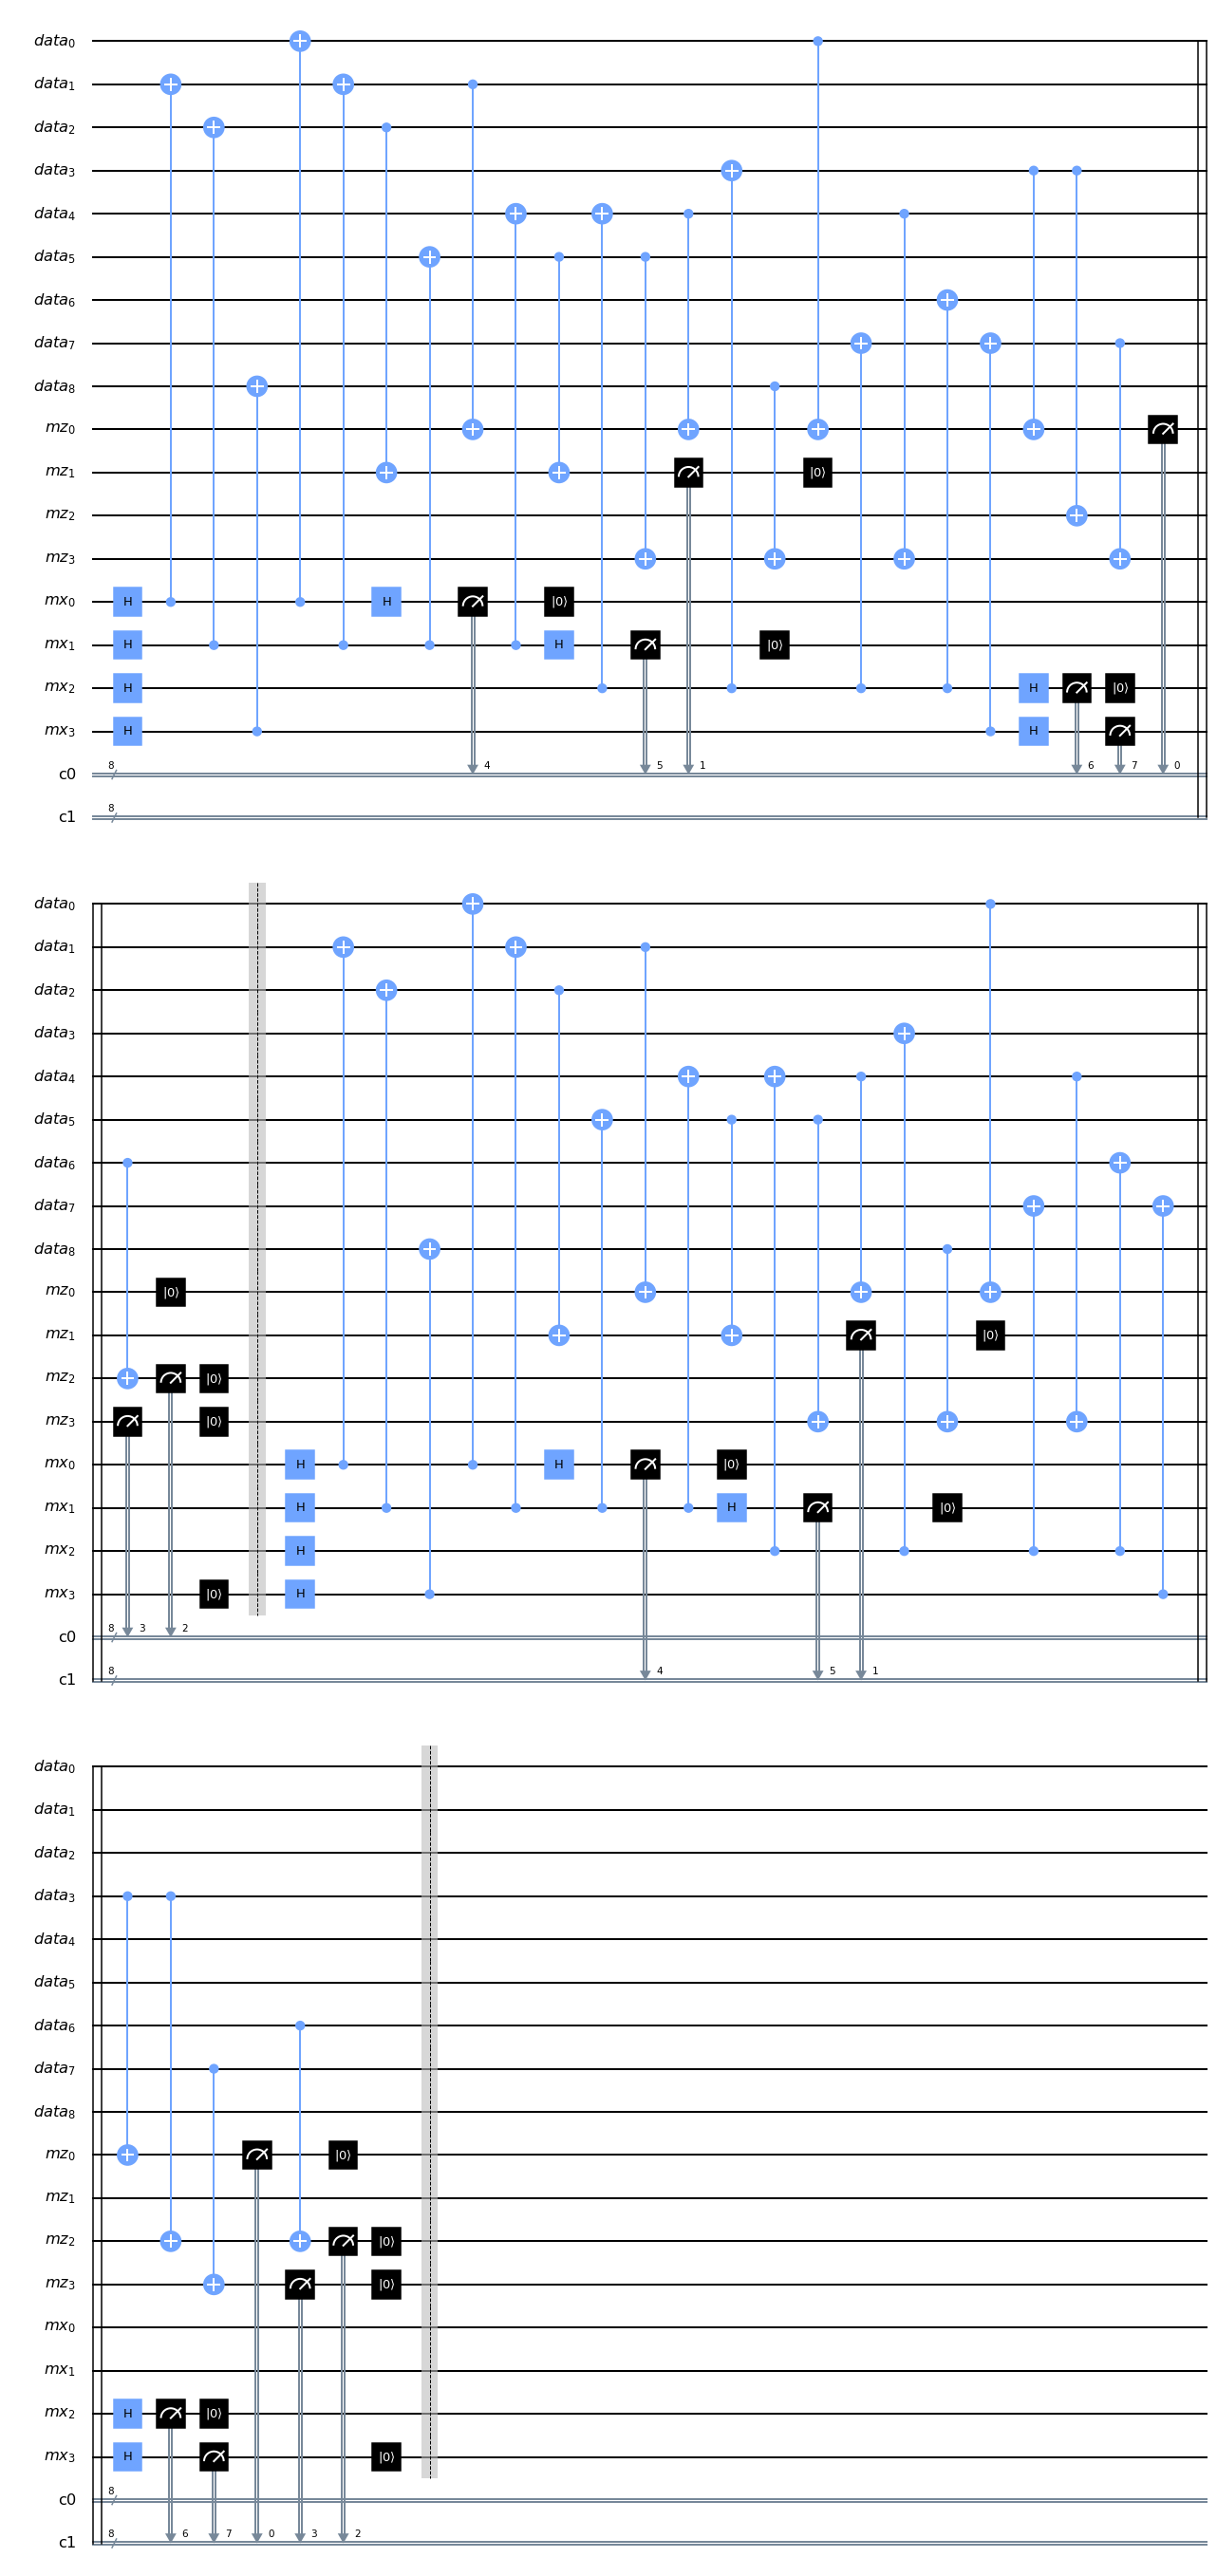

In [5]:
circ.draw('mpl')

# Example with error

In [6]:
# Pauli Y error at data qubit indexed 4
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
circ.y(qregisters["data"][4])
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'00011001 01110000': 75,
 '00101001 01000000': 63,
 '00111001 01010000': 60,
 '01001001 00100000': 76,
 '01011001 00110000': 50,
 '01101001 00000000': 58,
 '01111001 00010000': 55,
 '10001001 11100000': 58,
 '00001001 01100000': 65,
 '10011001 11110000': 47,
 '10101001 11000000': 64,
 '10111001 11010000': 67,
 '11001001 10100000': 78,
 '11011001 10110000': 64,
 '11101001 10000000': 80,
 '11111001 10010000': 64}

In [54]:
def parse_readout(params,readout_string):
    chunks=readout_string.split(" ")
    #chunks=chunks[1:]
    int_syndromes = [int(x, base=2) for x in chunks[::-1]]
    xor_syndromes = [a ^ b for (a, b) in zip(int_syndromes, int_syndromes[1:])]

    num_syn = params["num_syn"]
    mask_z = "1" * num_syn[0]
    mask_x = "1" * num_syn[1] + "0" * num_syn[0]
    x_syndromes = [(x & int(mask_x, base=2)) >> num_syn[0] for x in xor_syndromes]
    z_syndromes = [x & int(mask_z, base=2) for x in xor_syndromes]

    d = params["d"][0]
    X = []
    per_row_x = d // 2
    for T, syndrome in enumerate(x_syndromes):
        for loc in range(num_syn[1]):
            if syndrome & (1 << loc):
                row = -0.5 + loc // per_row_x
                col = (0.5 + (loc // per_row_x) % 2) + (loc % per_row_x) * 2
                X.append((row, col))

    Z = []
    per_row_z = d // 2 + 1
    for T, syndrome in enumerate(z_syndromes):
        for loc in range(num_syn[0]):
            if syndrome & (1 << loc):
                row = 0.5 + loc // per_row_z
                col = (0.5 - (loc // per_row_z) % 2) + (loc % per_row_z) * 2
                Z.append((row, col))
                
    return {"X":X,"Z":Z}

# Error Detection Example

In [8]:
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
circ.y(qregisters["data"][4])
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
counts=execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
readouts=list(counts.keys())
readouts_string=readouts[0]
readout=parse_readout(params,readouts_string)
print(readout)

{'X': [(0.5, 1.5), (1.5, 0.5)], 'Z': [(0.5, 0.5), (1.5, 1.5)]}


# Mapping to a Graph problem

In [6]:
def Syndrome_Graph(params):
    syndrome_graph_keys=["X","Z"]
    S={}
    node_map={}
    for syndrome_graph_key in syndrome_graph_keys:
        S[syndrome_graph_key]=nx.Graph()
        node_map[syndrome_graph_key]={}
    make_syndrome_graph(S,syndrome_graph_keys,node_map,params)   
    return S,node_map
            
def make_syndrome_graph(S,syndrome_graph_keys,node_map,params):
    start_nodes = {"Z": (0.5, 0.5), "X": (0.5, 1.5)}
    for syndrome_graph_key in syndrome_graph_keys:
        start_node = start_nodes[syndrome_graph_key]
        node_map[syndrome_graph_key][start_node] = S[syndrome_graph_key].add_node(start_node,pos=start_node)
        populate_syndrome_graph(start_node, [], syndrome_graph_key,1,S,node_map,params)

            
def populate_syndrome_graph(current_node,visited_nodes,syndrome_graph_key,edge_weight:int,S,node_map,params):
    visited_nodes.append(current_node)
    neighbors = []
    i = current_node[0]  # syndrome node x coordinate
    j = current_node[1]  # syndrome node y coordinate
    neighbors.append((i - 1, j - 1))  # up left
    neighbors.append((i + 1, j - 1))  # down left
    neighbors.append((i - 1, j + 1))  # up right
    neighbors.append((i + 1, j + 1))  # down right
        
    normal_neighbors = [n
                        for n in neighbors
                        if valid_syndrome(n, syndrome_graph_key,params)
                        and (n[0], n[1]) not in visited_nodes] 
        
    if not normal_neighbors:
        return
        
    # add neighbors
    for target_node in normal_neighbors:
            if target_node not in S[syndrome_graph_key].nodes():
            # add target_node to syndrome subgraph if it doesn't already exist
                node_map[syndrome_graph_key][target_node] = S[syndrome_graph_key].add_node(target_node,pos=target_node)

            S[syndrome_graph_key].add_edge(current_node,target_node,weight=edge_weight)  # add edge between current_node and target_node
            
    for target in normal_neighbors:
        populate_syndrome_graph(target, visited_nodes, syndrome_graph_key, edge_weight,S,node_map,params)
        
def valid_syndrome(node,syndrome_graph_key,params):
    i = node[0]
    j = node[1]
    d= params["d"][0]
        
    if syndrome_graph_key == "Z":
        if i > 0 and i < d - 1 and j < d and j > -1:
            return True
        else:
            return False
    elif syndrome_graph_key == "X":
        if j > 0 and j < d - 1 and i < d and i > -1:
            return True
        else:
            return False

In [7]:
def make_error_graph(nodes,S,syndrome_graph_key,node_map,params):
    node_map_error={}
    error_graph = nx.Graph()

        
    # add all nodes to error_graph
    for node in nodes:
        if node not in error_graph.nodes():
            node_map_error[node] = error_graph.add_node(node,pos=node)

    shortest_distance_mat=nx.floyd_warshall_numpy(S[syndrome_graph_key])

    
    for source, target in combinations(nodes, 2):
        nodes_whole=list(node_map[syndrome_graph_key].keys())
        i=Index_(nodes_whole,source)
        j=Index_(nodes_whole,target)
        distance = shortest_distance_mat[i][j]
        error_graph.add_edge((source), (target), weight=float(-1*distance))
    return error_graph


def shortest_distance(node_map,params):
    nodes=list(node_map.keys())
    d=params["d"][0]
    n=((d*d-1)//2)
    matrix=np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(i+1,n):
            distance=np.linalg.norm(np.array(nodes[i])-np.array(nodes[j]))
            distance=math.floor(distance)
            matrix[i][j]=distance
            matrix[j][i]=distance
    return matrix

def Index_(nodes_whole,node):
    idx=0
    for i in range (len(nodes_whole)):
        if nodes_whole[i]==node:
            return idx
        else:
            idx=idx+1
    return idx

def Decoder(readout,S,node_map,params):
    matches={"X":[],"Z":[]}
    for syndrome_graph_key in ["X","Z"]:
        nodes=readout[syndrome_graph_key]
        error_graph=make_error_graph(nodes,S,syndrome_graph_key,node_map,params)
        match=run_mwpm(error_graph)
        matches[syndrome_graph_key].append(match)
    return matches

def run_mwpm(matching_graph):
    matches_idxs = nx.max_weight_matching(matching_graph, maxcardinality=True,weight="weight")
    return matches_idxs

def draw(graph):
    pos=nx.get_node_attributes(graph,'pos')
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw(graph,pos,with_labels = True)
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

# Example

In [170]:
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
circ.y(qregisters["data"][4])
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
counts=execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
readouts=list(counts.keys())
readouts_string=readouts[0]
readout=parse_readout(params,readouts_string)
S,node_map=Syndrome_Graph(params)

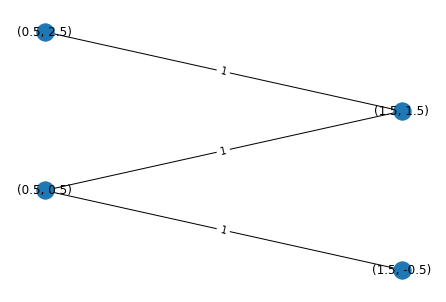

In [139]:
draw(S["Z"])

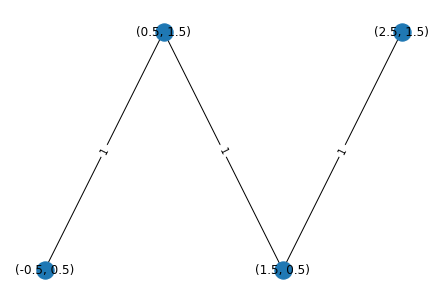

In [140]:
draw(S["X"])

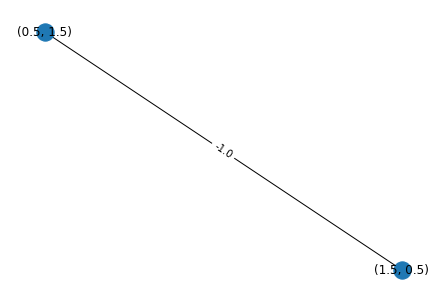

In [141]:
error_map_X=make_error_graph(readout["X"],S,"X",node_map,params)
draw(error_map_X)

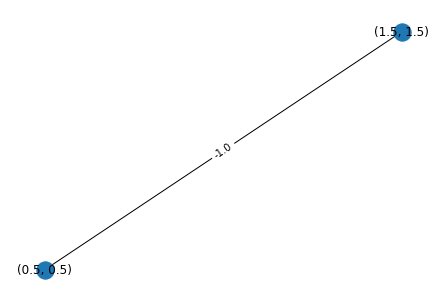

In [142]:
error_map_Z=make_error_graph(readout["Z"],S,"Z",node_map,params)
draw(error_map_Z)

In [171]:
results=Decoder(readout,S,node_map,params)
print(results)

{'X': [{((0.5, 1.5), (1.5, 0.5))}], 'Z': [{((0.5, 0.5), (1.5, 1.5))}]}


# Correction Operators

In [8]:
def correction(results,S,circ,params):
    d=params["d"][0]
    
    X_error=[]
    for i in results['Z'][0]:
        source=i[0]
        target=i[1]
        paths=nx.shortest_path(S["Z"],source,target)
        for j in range(len(paths)-1):
            s=paths[j]
            t=paths[j+1]
            qubit_coordinate=((s[0]+t[0])/2,(s[1]+t[1])/2)
            X_error.append(d*qubit_coordinate[0]+qubit_coordinate[1])
    
    Z_error=[]
    for i in results['X'][0]:
        source=i[0]
        target=i[1]
        paths=nx.shortest_path(S["X"],source,target)
        for j in range(len(paths)-1):
            s=paths[j]
            t=paths[j+1]
            qubit_coordinate=((s[0]+t[0])/2,(s[1]+t[1])/2)
            Z_error.append(d*qubit_coordinate[0]+qubit_coordinate[1])
        
    for qubit_idx in X_error:
        if qubit_idx in Z_error:
            circ.y(int(qubit_idx))
        else:
            circ.x(int(qubit_idx))
    
    for qubit_idx in Z_error:
        if qubit_idx not in X_error:
            circ.z(int(qubit_idx))
            
    return circ

In [172]:
circ=correction(results,S,circ,params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'00010000 01111001 00010000': 78,
 '00100000 01001001 00100000': 77,
 '00110000 01011001 00110000': 61,
 '01000000 00101001 01000000': 65,
 '01010000 00111001 01010000': 74,
 '01100000 00001001 01100000': 66,
 '00000000 01101001 00000000': 72,
 '01110000 00011001 01110000': 58,
 '10000000 11101001 10000000': 68,
 '10010000 11111001 10010000': 62,
 '10100000 11001001 10100000': 66,
 '10110000 11011001 10110000': 58,
 '11000000 10101001 11000000': 55,
 '11010000 10111001 11010000': 44,
 '11100000 10001001 11100000': 53,
 '11110000 10011001 11110000': 67}

# Virtual Nodes

In [9]:
def get_virtual(params):
    d=params["d"][0]
    virtual_nodes={"X":[],"Z":[]}
    
    # Z-virtual nodes
    for i in range(0,d,2):
        virtual_nodes["Z"].append((-0.5,i-0.5))
        virtual_nodes["Z"].append((d-0.5,i+0.5))
        
    # X-virtual nodes
    for i in range(0,d,2):
        virtual_nodes["X"].append((i+0.5,-0.5))
        virtual_nodes["X"].append((i-0.5,d-0.5))
        
    return virtual_nodes

In [10]:
def Syndrome_Graph_with_virtual(params):
    syndrome_graph_keys=["X","Z"]
    S={}
    node_map={}
    for syndrome_graph_key in syndrome_graph_keys:
        S[syndrome_graph_key]=nx.Graph()
        #S[syndrome_graph_key]=rx.PyGraph()
        node_map[syndrome_graph_key]={}
    make_syndrome_graph_with_virtual(S,syndrome_graph_keys,node_map,params)   
    return S,node_map

def make_syndrome_graph_with_virtual(S,syndrome_graph_keys,node_map,params):
    start_nodes = {"Z": (0.5, 0.5), "X": (0.5, 1.5)}
    virtual_nodes=get_virtual(params)
    for syndrome_graph_key in syndrome_graph_keys:
        start_node = start_nodes[syndrome_graph_key]
        node_map[syndrome_graph_key][start_node] = S[syndrome_graph_key].add_node(start_node,pos=start_node)
        populate_syndrome_graph_with_virtual(start_node, [], syndrome_graph_key, 1,S,node_map,params,virtual_nodes[syndrome_graph_key])

            
def populate_syndrome_graph_with_virtual(current_node,visited_nodes,syndrome_graph_key,edge_weight:int,S,node_map,params,virtual_nodes):
    visited_nodes.append(current_node)
    neighbors = []
    i = current_node[0]  # syndrome node x coordinate
    j = current_node[1]  # syndrome node y coordinate
    neighbors.append((i - 1, j - 1))  # up left
    neighbors.append((i + 1, j - 1))  # down left
    neighbors.append((i - 1, j + 1))  # up right
    neighbors.append((i + 1, j + 1))  # down right
        
    normal_neighbors = [n
                        for n in neighbors
                        if valid_syndrome(n, syndrome_graph_key,params)
                        and (n[0], n[1]) not in visited_nodes] 
    
    virtual_neighbors = [n
                        for n in neighbors
                        if n in virtual_nodes 
                        and (n[0],n[1]) not in visited_nodes]
        
    if not normal_neighbors and not virtual_neighbors:
        return
        
    # add normal neighbors
    for target_node in normal_neighbors:
        if target_node not in S[syndrome_graph_key].nodes():
            # add target_node to syndrome subgraph if it doesn't already exist
            node_map[syndrome_graph_key][target_node] = S[syndrome_graph_key].add_node(target_node,pos=target_node)

        S[syndrome_graph_key].add_edge(current_node,target_node,weight=edge_weight)  # add edge between current_node and target_node
            
    # add virtual neighbors
    for target_node in virtual_neighbors:
        if target_node not in S[syndrome_graph_key].nodes():
            # add target_node to syndrome subgraph if it doesn't already exist
            node_map[syndrome_graph_key][target_node] = S[syndrome_graph_key].add_node(target_node,pos=target_node)

        S[syndrome_graph_key].add_edge(current_node,target_node,weight=edge_weight)  # add edge between current_node and target_node
    
    # recursively travel through normal neighbors
    for target in normal_neighbors:
        populate_syndrome_graph_with_virtual(target, visited_nodes, syndrome_graph_key, edge_weight,S,node_map,params,virtual_nodes)
        
    # recursively travel through virtual neighbors
    for target in virtual_neighbors:
        populate_syndrome_graph_with_virtual(target, visited_nodes, syndrome_graph_key, edge_weight,S,node_map,params,virtual_nodes)

In [11]:
def make_error_graph_with_virtual(nodes,S,syndrome_graph_key,node_map,params,virtual_nodes):
    node_map_error={}
    error_graph = nx.Graph()
    # Ensure even number of readout nodes
    make_even = (len(nodes) % 2 != 0)    
    # add all nodes from readout to error_graph
    for node in nodes:
        if node not in error_graph.nodes():
            node_map_error[node] = error_graph.add_node(node,pos=node)
    #adding virtual nodes to error graph and list of nodes
    for node in virtual_nodes:
        node_map_error[node] = error_graph.add_node(node,pos=node)
    nodes=nodes+virtual_nodes
    shortest_distance_mat=nx.floyd_warshall_numpy(S[syndrome_graph_key])
    for source, target in combinations(nodes, 2):
        nodes_whole=list(node_map[syndrome_graph_key].keys())
        i=Index_(nodes_whole,source)
        j=Index_(nodes_whole,target)
        if (source in virtual_nodes) and (target in virtual_nodes):
            distance = 0.0
            error_graph.add_edge(source,target,weight=distance)
        else:
            distance = shortest_distance_mat[i][j]
            error_graph.add_edge(source, target, weight=float(-1*distance))   
    if make_even:
        source = (-1, -1)
        node_map_error[source] = error_graph.add_node(source,pos=source)
        for target in virtual_nodes:
                error_graph.add_edge(source, target, weight=0)
        virtual_nodes.append(source)
                
    return error_graph , virtual_nodes

def shortest_distance_with_virtual(node_map,params,virtual_nodes):
    nodes=list(node_map.keys())
    d=params["d"][0]
    n=(((d*d)-1)//2)+d+1
    matrix=np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(i+1,n):
            if (nodes[i] in virtual_nodes) and (nodes[j] in virtual_nodes):
                pass
            else:
                distance=np.linalg.norm(np.array(nodes[i])-np.array(nodes[j]))
                distance=math.floor(distance)
                matrix[i][j]=distance
                matrix[j][i]=distance
    return matrix 
    
def Decoder_with_virtual(readout,S,node_map,params):
    matches={"X":[],"Z":[]}
    virtual_nodes=get_virtual(params)
    for syndrome_graph_key in ["X","Z"]:
        nodes=readout[syndrome_graph_key]
        error_graph,virtual=make_error_graph_with_virtual(nodes,S,syndrome_graph_key,node_map,params,virtual_nodes[syndrome_graph_key])
        match=run_mwpm(error_graph)
        for nodes_pair in match:
            if (nodes_pair[0] in virtual) and (nodes_pair[1] in virtual):
                pass
            else:
                matches[syndrome_graph_key].append(nodes_pair)
    return matches

def draw_with_virtual(graph,virtual_nodes):
    nodes=list(graph.nodes)
    color_map=[]
    for node in nodes:
        if node in virtual_nodes:
            color_map.append('red')
        else:
            color_map.append('blue')
    pos=nx.get_node_attributes(graph,'pos')
    labels = nx.get_edge_attributes(graph,'weight')
    nx.draw(graph,pos,node_color=color_map,with_labels = True)
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    
            


# Example

In [74]:
import time
start=time.time()
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
circ.y(qregisters["data"][4])
#circ.z(qregisters["data"][7])
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
counts=execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)
end=time.time()
print(end-start)

{'00011001 01110000': 66, '00101001 01000000': 60, '00111001 01010000': 55, '01001001 00100000': 70, '01011001 00110000': 53, '01101001 00000000': 68, '01111001 00010000': 43, '10001001 11100000': 81, '00001001 01100000': 81, '10011001 11110000': 57, '10101001 11000000': 71, '10111001 11010000': 71, '11001001 10100000': 63, '11011001 10110000': 50, '11101001 10000000': 70, '11111001 10010000': 65}
0.18426084518432617


In [77]:
time_=[]
for i in range(10):
    import time
    start=time.time()
    params={"d":(3,3)}
    params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
    circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
    #circ.y(qregisters["data"][4])
    #circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
    counts=execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
    end=time.time()
    time_.append(end-start)
print(sum(time_)/len(time_))

0.09235687255859375


In [68]:
readouts=list(counts.keys())
readouts_string=readouts[0]
readout=parse_readout(params,readouts_string)
print(readout)

{'X': [(0.5, 1.5), (1.5, 0.5)], 'Z': [(0.5, 0.5), (1.5, 1.5)]}


In [58]:
S,node_map=Syndrome_Graph_with_virtual(params)
results=Decoder_with_virtual(readout,S,node_map,params)
print(results)

{'X': [((0.5, 1.5), (-0.5, 0.5)), ((1.5, 0.5), (2.5, 1.5))], 'Z': [((-0.5, -0.5), (0.5, 0.5))]}


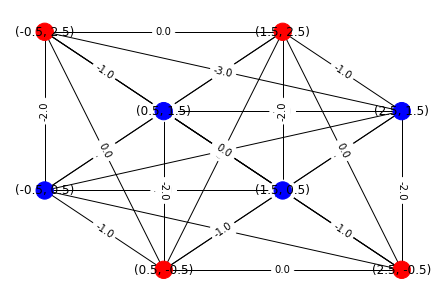

In [60]:
virtual_nodes=get_virtual(params)
error_graph,virtual=make_error_graph_with_virtual(readout["X"],S,"X",node_map,params,virtual_nodes["X"])
draw_with_virtual(error_graph,virtual)

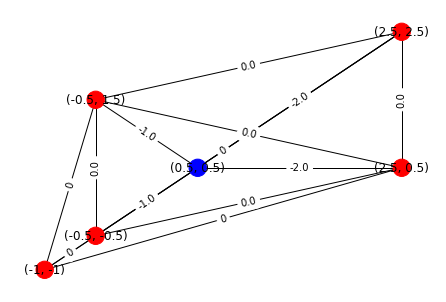

In [61]:
error_graph,virtual=make_error_graph_with_virtual(readout["Z"],S,"Z",node_map,params,virtual_nodes["Z"])
draw_with_virtual(error_graph,virtual)

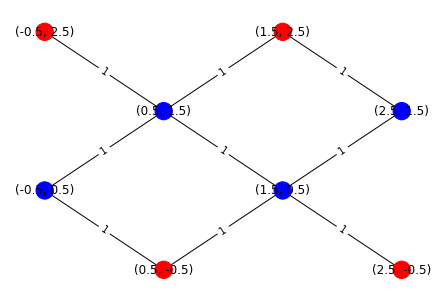

In [62]:
draw_with_virtual(S["X"],virtual_nodes["X"])

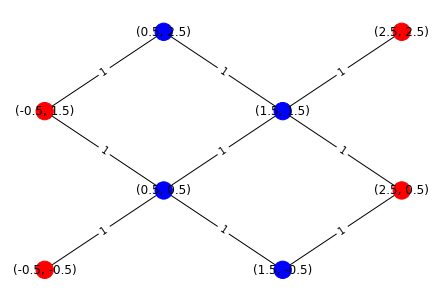

In [63]:
draw_with_virtual(S["Z"],virtual_nodes["Z"])

# Correction with virtual

In [12]:
def correction_with_virtual(results,S,circ,params):
    d=params["d"][0]
    
    X_error=[]
    for i in results['Z']:
        source=i[0]
        target=i[1]
        paths=nx.shortest_path(S["Z"],source,target)
        for j in range(len(paths)-1):
            s=paths[j]
            t=paths[j+1]
            qubit_coordinate=((s[0]+t[0])/2,(s[1]+t[1])/2)
        #qubit_coordinate=((i[0][0]+i[1][0])/2,(i[0][1]+i[1][1])/2)
            X_error.append(d*qubit_coordinate[0]+qubit_coordinate[1])
    
    Z_error=[]
    for i in results['X']:
        source=i[0]
        target=i[1]
        paths=nx.shortest_path(S["X"],source,target)
        for j in range(len(paths)-1):
            s=paths[j]
            t=paths[j+1]
            qubit_coordinate=((s[0]+t[0])/2,(s[1]+t[1])/2)
            Z_error.append(d*qubit_coordinate[0]+qubit_coordinate[1])
        #qubit_coordinate=((i[0][0]+i[1][0])/2,(i[0][1]+i[1][1])/2)
        #Z_error.append(d*qubit_coordinate[0]+qubit_coordinate[1])
        
    for qubit_idx in X_error:
        circ.x(int(qubit_idx))
    
    for qubit_idx in Z_error:
        circ.z(int(qubit_idx))
            
    return circ

In [73]:
circ=correction_with_virtual(results,S,circ,params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'00010000 11100001 00010000': 74,
 '00100000 11010001 00100000': 70,
 '00110000 11000001 00110000': 64,
 '01000000 10110001 01000000': 50,
 '01010000 10100001 01010000': 54,
 '01100000 10010001 01100000': 66,
 '01110000 10000001 01110000': 56,
 '10000000 01110001 10000000': 70,
 '10010000 01100001 10010000': 73,
 '10100000 01010001 10100000': 64,
 '10110000 01000001 10110000': 60,
 '11000000 00110001 11000000': 74,
 '11010000 00100001 11010000': 59,
 '11100000 00010001 11100000': 49,
 '11110000 00000001 11110000': 61,
 '00000000 11110001 00000000': 80}

# Logical Readouts

In [1]:
# Logical Z readout
def readout_z_into_ancilla(params,qregisters,circ):
    d=params["d"][0]
    circ.reset(qregisters["ancilla"])
    for i in range(d):
        circ.cx(qregisters["data"][i],qregisters["ancilla"])
        
# Logical X readout    
def readout_x_into_ancilla(params,qregisters,circ):
    d=params["d"][0]
    circ.reset(qregisters["ancilla"])
    circ.h(qregisters["ancilla"])
    for i in range(0,d*d,d):
        circ.cx(qregisters["ancilla"],qregisters["data"][i])
    circ.h(qregisters["ancilla"])

def readout_z(params,qregisters,circ):
    params["num_readout"] += 1
    cregister={}
    cregister["Logical_readout_z".format(params["num_readout"])]=ClassicalRegister(1)
    circ.add_register(cregister["Logical_readout_z".format(params["num_readout"])])
    readout_z_into_ancilla(params,qregisters,circ)
    circ.measure(qregisters["ancilla"],cregister["Logical_readout_z".format(params["num_readout"])])
    circ.barrier()


def readout_x(params,qregisters,circ):
    params["num_readout"] += 1
    cregister={}
    cregister["Logical_readout_x".format(params["num_readout"])]=ClassicalRegister(1)
    circ.add_register(cregister["Logical_readout_x".format(params["num_readout"])])
    readout_x_into_ancilla(params,qregisters,circ)
    circ.measure(qregisters["ancilla"],cregister["Logical_readout_x".format(params["num_readout"])])
    circ.barrier()
    
def Logical_readout(params,qregisters,circ,logical_readout_type):
    if logical_readout_type=="Z":
        readout_z(params,qregisters,circ)
    elif logical_readout_type=="X": 
        readout_x(params,qregisters,circ)

In [5]:
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
Logical_readout(params,qregisters,circ,"Z")
execute(circ, Aer.get_backend('qasm_simulator'),shots=1024).result().get_counts()

{'0 00000000 00000000': 71,
 '0 00010000 00010000': 63,
 '0 00100000 00100000': 66,
 '0 00110000 00110000': 62,
 '0 01000000 01000000': 66,
 '0 01010000 01010000': 75,
 '0 01100000 01100000': 81,
 '0 01110000 01110000': 47,
 '0 10000000 10000000': 69,
 '0 10010000 10010000': 54,
 '0 10100000 10100000': 58,
 '0 10110000 10110000': 85,
 '0 11000000 11000000': 54,
 '0 11010000 11010000': 48,
 '0 11100000 11100000': 57,
 '0 11110000 11110000': 68}

# Path Degeneracy

In [ ]:
# Degeneracy functions
def path_degeneracy(node_1,node_2,syndrome_graph_key,node_map,num_shortest_paths,
                    shortest_distance_mat,params,S):
    
    virtual_nodes=get_virtual(params)[syndrome_graph_key]
    nodes_whole=list(node_map[syndrome_graph_key].keys())
    idx_1=Index_(nodes_whole,node_1)
    idx_2=Index_(nodes_whole,node_2)
    
    source = None
    if node_1 in virtual_nodes:
        target = idx_1  # virtual
        source = idx_2
    elif node_2 in virtual_nodes:
        target = idx_2  # virtual
        source = idx_1
        
    if source:
        shortest_distance = shortest_distance_mat[source][target]
        total_deg = 0
        for node in virtual_nodes:
            node_idx = Index_(nodes_whole,node)
            if shortest_distance_mat[source][node_idx] == shortest_distance:
                deg, num_shortest_paths = path_degeneracy_helper(source, node_idx,syndrome_graph_key, 
                                                                 num_shortest_paths,nodes_whole,S)
                total_deg += deg
    else:
        total_deg, num_shortest_paths = path_degeneracy_helper(idx_1, idx_2, syndrome_graph_key, 
                                                               num_shortest_paths,nodes_whole,S)
    return total_deg ,num_shortest_paths


def path_degeneracy_helper(idx_1, idx_2, syndrome_graph_key, num_shortest_paths,nodes_whole,S):
    if idx_1 in num_shortest_paths.keys():
        return num_shortest_paths[idx_1][idx_2], num_shortest_paths
    elif idx_2 in num_shortest_paths.keys():
        return num_shortest_paths[idx_1][idx_2], num_shortest_paths
    else:
        num_shortest_paths[idx_1] = (num_shortest_paths_unweighted(S[syndrome_graph_key], idx_1,nodes_whole))
        return num_shortest_paths[idx_1][idx_2], num_shortest_paths
    
    
def num_shortest_paths_unweighted(G,source_idx,nodes_whole):
    source=nodes_whole[source_idx]
    num_shortest_paths=[]
    for target in nodes_whole:
        num_shortest=len([p for p in (nx.all_shortest_paths(G,source,target))])
        num_shortest_paths.append(num_shortest)
    return num_shortest_paths

In [ ]:
def make_error_graph_with_virtual_degeneracy(nodes,S,syndrome_graph_key,node_map,params,virtual_nodes,err_prob):
    node_map_error={}
    error_graph = nx.Graph()
    
    # Ensure even number of readout nodes
    make_even = (len(nodes) % 2 != 0)
        
    # add all nodes from readout to error_graph
    for node in nodes:
        if node not in error_graph.nodes():
            node_map_error[node] = error_graph.add_node(node,pos=node)
    
    #adding virtual nodes to error graph and list of nodes
    for node in virtual_nodes:
        node_map_error[node] = error_graph.add_node(node,pos=node)
    
    nodes=nodes+virtual_nodes
    
    #shortest_distance_mat = shortest_distance_with_virtual(node_map[syndrome_graph_key],params,virtual_nodes)
    shortest_distance_mat=nx.floyd_warshall_numpy(S[syndrome_graph_key])
    
    num_shortest_paths={}
    for source, target in combinations(nodes, 2):
        nodes_whole=list(node_map[syndrome_graph_key].keys())
        i=Index_(nodes_whole,source)
        j=Index_(nodes_whole,target)
        if (source in virtual_nodes) and (target in virtual_nodes):
            distance = 0.0
            error_graph.add_edge(source,target,weight=distance)
        else:
            distance = shortest_distance_mat[i][j]
            if err_prob:
                deg,num_shortest_paths=path_degeneracy(source,target,syndrome_graph_key,node_map,num_shortest_paths,shortest_distance_mat,params,S)
                distance = distance - math.log(deg) / (math.log1p(-1.0*err_prob) - math.log(err_prob))
            error_graph.add_edge(source, target, weight=float(-1*distance))
        
    if make_even:
        source = (-1, -1)
        node_map_error[source] = error_graph.add_node(source,pos=source)
        for target in virtual_nodes:
                error_graph.add_edge(source, target, weight=0)
        virtual_nodes.append(source)
                
    return error_graph , virtual_nodes

def Decoder_with_virtual_degeneracy(readout,S,node_map,params,err_prob):
    matches={"X":[],"Z":[]}
    virtual_nodes=get_virtual(params)
    for syndrome_graph_key in ["X","Z"]:
        nodes=readout[syndrome_graph_key]
        error_graph,virtual=make_error_graph_with_virtual_degeneracy(nodes,S,syndrome_graph_key,node_map,params,virtual_nodes[syndrome_graph_key],err_prob)
        match=run_mwpm(error_graph)
        for nodes_pair in match:
            if (nodes_pair[0] in virtual) and (nodes_pair[1] in virtual):
                pass
            else:
                matches[syndrome_graph_key].append(nodes_pair)
    return matches

# Error Rate Calculation

In [14]:
def Find_matches(readout,params,err_prob):
    S,node_map=Syndrome_Graph_with_virtual(params)
    matches=Decoder_with_virtual_degeneracy(readout,S,node_map,params,err_prob)
    return matches

def is_crossing_readout_path(match,logical_readout_type,virtual_nodes):
    source,target = match
    if logical_readout_type=="Z": 
        return (source in virtual_nodes["Z"] and source[0] == -0.5) or (
                target in virtual_nodes["Z"] and target[0] == -0.5)
    if logical_readout_type=="X": 
        return (source in virtual_nodes["X"] and source[1] == -0.5) or (
                target in virtual_nodes["X"] and target[1] == -0.5)

def correct_readout(readout_string,logical_readout_type,virtual_nodes,params,err_prob):
    chunks=readout_string.split(" ")
    logical_qubit_value=int(chunks[0])
    readout=parse_readout(params,readout_string)
    matches=Find_matches(readout,params,err_prob)[logical_readout_type]
    for match in matches:
        if is_crossing_readout_path(match,logical_readout_type,virtual_nodes):
            logical_qubit_value = (logical_qubit_value+1) % 2
    return logical_qubit_value

def logical_error_rate(readout_strings,correct_logical_value,virtual_nodes,params,err_prob=None):
    total_counts=0
    error_counts=0
    for readout,counts in readout_strings.items():
        total_counts += counts
        predicted_logical_value=correct_readout(readout,"Z",virtual_nodes,params,err_prob)
        if predicted_logical_value != correct_logical_value:
            error_counts += counts
    return error_counts/total_counts

def id_block(circ,qregisters):
    circ.id(qregisters["data"])        
     

In [16]:
def Error_Benchmarking(params,circ,physical_error_rates,correct_logical_value,noise_model_f=None,with_degeneracy=False):
    virtual_nodes=get_virtual(params)
    data={}
    data["physical_error_rates"]=sorted(physical_error_rates)
    data["logical_error_rates"]=[]
    pbar=tqdm(data["physical_error_rates"])
    for physical_error_rate in pbar:
        results=(execute(circ,Aer.get_backend("qasm_simulator"),noise_model=noise_model_f(physical_error_rate),optimization_level=0).result().get_counts())
        if with_degeneracy:
            logical_error_rate_value = logical_error_rate(results,correct_logical_value,virtual_nodes,params,err_prob=physical_error_rate)
        else:
            logical_error_rate_value = logical_error_rate(results,correct_logical_value,virtual_nodes,params)
        data["logical_error_rates"].append(logical_error_rate_value)
    return data
        
    

In [17]:
# Defining noise models

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import Aer
def get_noise_model(p_err):

    error_gate1 = pauli_error([("X", p_err / 2), ("Z", p_err / 2), ("I", 1 - p_err)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "id")
    return noise_model

def depolarizing_channel(p_err):
    error_gate1 = depolarizing_error(p_err,1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "id")
    return noise_model

# Degeneracy vs. Without Degeneracy

In [37]:
# Without Degeneracy
correct_logical_value=0
physical_error_rates=[1e-3,5*1e-3,1e-2,5*1e-2,1e-1,0.12,0.14,0.16,0.18,0.20,0.25,0.27,0.31,0.36]
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
id_block(circ,qregisters)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
Logical_readout(params,qregisters,circ,"Z")
data=Error_Benchmarking(params,circ,physical_error_rates,correct_logical_value,noise_model_f=get_noise_model,with_degeneracy=False)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:18<00:00,  1.88s/it]


In [38]:
# With degeneracy
correct_logical_value=0
physical_error_rates=[1e-3,5*1e-3,1e-2,5*1e-2,1e-1,0.12,0.14,0.16,0.18,0.20,0.25,0.27,0.31,0.36]
params={"d":(3,3)}
params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
id_block(circ,qregisters)
circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
Logical_readout(params,qregisters,circ,"Z")
data_2=Error_Benchmarking(params,circ,physical_error_rates,correct_logical_value,noise_model_f=get_noise_model,with_degeneracy=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:26<00:00,  2.89s/it]


Text(0, 0.5, 'Logical Error rate')

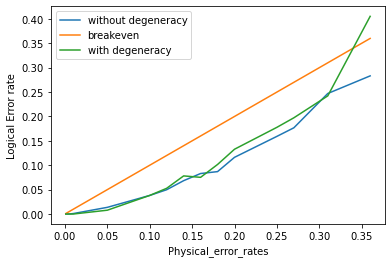

In [39]:
plt.plot(data["physical_error_rates"],data["logical_error_rates"],label="without degeneracy")
plt.plot(physical_error_rates,physical_error_rates,label="breakeven")
plt.plot(data_2["physical_error_rates"],data_2["logical_error_rates"],label="with degeneracy")
plt.legend()
plt.xlabel("Physical_error_rates")
plt.ylabel("Logical Error rate")


# Logical Error Rate vs. Physical Error Rate (for different d)

## Pauli Noise Model


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.85s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:36<00:00, 24.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [19:13<00:00, 128.01s/it]

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [1:18:05<00:00, 536.08s/it]


Text(0.5, 0, 'Physical Error Rate')

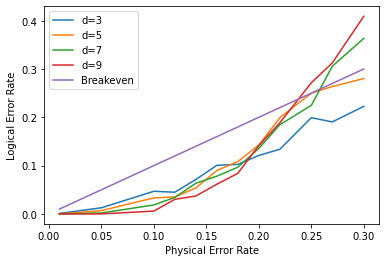

In [40]:
Logic_error=[]
for d in range(3,11,2):
    correct_logical_value=0
    physical_error_rates=[1e-2,5*1e-2,1e-1,0.12,0.14,0.16,0.18,0.2,0.22,0.25,0.27,0.3]
    params={"d":(d,d)}
    params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
    circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
    id_block(circ,qregisters)
    circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
    Logical_readout(params,qregisters,circ,"Z")
    data_dp=Error_Benchmarking(params,circ,physical_error_rates,correct_logical_value,noise_model_f=get_noise_model,with_degeneracy=True)
    Logic_error.append(data_dp["logical_error_rates"])
    plt.plot(data_dp["physical_error_rates"],data_dp["logical_error_rates"],label="d={}".format(d))
plt.plot(physical_error_rates,physical_error_rates,label="Breakeven")
plt.legend()
plt.ylabel("Logical Error Rate")
plt.xlabel("Physical Error Rate")

## Empirical Relationship 

In [49]:
pth=0.19
physical_error_rates=[1e-2,5*1e-2,1e-1,0.12,0.14,0.16,0.18,0.2,0.22,0.25,0.27,0.3]
P_L=[]
for i in range(4):
    d=2*i+1
    de=(d+1)/2
    p_l=[]
    for j in range(len(physical_error_rates)):
        p=physical_error_rates[j]
        p_l.append(0.03*(p/pth)**de)
    P_L.append(p_l)

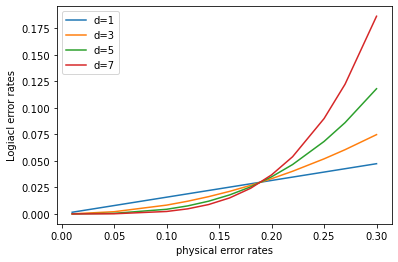

In [52]:
for i in range(4):
    plt.plot(physical_error_rates,P_L[i],label="d={}".format(2*i+1)) 
plt.xlabel("physical error rates")
plt.ylabel("Logiacl error rates")
plt.legend()

## Depolarizing Channel


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.87s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:49<00:00, 26.42s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [20:32<00:00, 135.36s/it]

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [1:22:26<00:00, 590.23s/it]


Text(0.5, 0, 'Physical Error Rate')

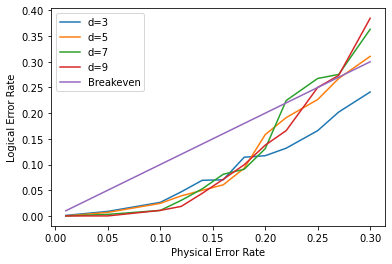

In [53]:
Logic_error_dp=[]
for d in range(3,11,2):
    correct_logical_value=0
    physical_error_rates=[1e-2,5*1e-2,1e-1,0.12,0.14,0.16,0.18,0.2,0.22,0.25,0.27,0.3]
    params={"d":(d,d)}
    params,qregisters,qubit_indices,stabilizers,circ=SurfaceCodeQubit(params)
    circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
    id_block(circ,qregisters)
    circ=stabilize(params,qregisters,qubit_indices,stabilizers,circ)
    Logical_readout(params,qregisters,circ,"Z")
    data_dp=Error_Benchmarking(params,circ,physical_error_rates,correct_logical_value,noise_model_f=depolarizing_channel,with_degeneracy=True)
    Logic_error.append(data_dp["logical_error_rates"])
    plt.plot(data_dp["physical_error_rates"],data_dp["logical_error_rates"],label="d={}".format(d))
plt.plot(physical_error_rates,physical_error_rates,label="Breakeven")
plt.legend()
plt.ylabel("Logical Error Rate")
plt.xlabel("Physical Error Rate")